<a href="https://colab.research.google.com/github/envgp/taking_the_pulse_ocean/blob/master/notebooks/pulse_ocean_with_answers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 3: Taking the Pulse of the Oceans & Fishing Activity

2024-02-01

Shin Nakayama (shinn1@stanford.edu) & Fio Micheli (micheli@stanford.edu)

[Stanford Center for Ocean Solutions](https://oceansolutions.stanford.edu), Doerr School of Sustainability

This lab is supposed be submitted by February 8, 2023. You are supposed to put your answer questions within this notebook and share the completed notebook with shinn1@stanford.edu using the `Share` banner located at the top right corner of this notebook. When sharing your notebook, please change the name of the notebook and add your name and sunetid (e.g., `3_hydrosphere_oceans_firstname_lastname_sunetid.ipynb`)

## INTRODUCTION TO THE ASSIGNMENT
Fisheries play a vital role in our food security, economy and ecosystem, while posing significant impacts on the oceans. Industrialization of fisheries has allowed us to catch more fish with engine-powered fishing fleets and gears. Non-selective fishing gears have let bycatch of unwanted and endangered species, while bottom trawlers have killed coral reefs by dragging the nets over seabeds. Currently, 35% of the fish population is overfished, and a study predicts that there will be no fish in the ocean by 2048, calling for better fisheries management.

Data sets used this assignment are: 1) global fishing effort, 2) regional fishing effort, 3) ocean chlorophyll a and sea surface temperature, and 4) shapefile of exclusive economic zones (EEZ).  
1. `fishing_hours.parquet` &mdash; A pre-processed grid data of daily fishing hours from 2016-01-01 to 2021-12-31, sumed within 1 × 1-degree grids. The original data are composed of locations, timestamp, and fishing hours associated with each AIS signal. Data taken from [Global Fishing Watch](https://globalfishingwatch.org).
    - `date`: year-month-day
    - `lat`: latitude
    - `lon`: longitude
    - `gear`: fishing gear type (trawlers, purse seines, etc.)
    - `flag`: vessel flag in ISO 3 code (that is, State which a vessel is registered to)
    - `fishing_hours`: total fishing hours in a 1 x 1-degree grid
2. `fishing_hours_x.parquet` &mdash; A pre-processed grid data of daily fishing hours from 2016-01-01 to 2021-12-31, sumed within 0.1 × 0.1-degree grids, for specific regions.
    - `fishing_hours_peru.parquet`: Near Peru with longitude [-100, -60] and latitude [-30, 10]
    - `fishing_hours_w_africa.parquet`: Near West Africa with longitude [-40, 0] and latitude [-10, 30]
    - `fishing_hours_pacific.parquet` : in the Pacific with longitude [140, 180] and latitude [-35, 5]    
3. `modis.parquet` &mdash; A pre-processed grid data of monthly mean measurements by MODIS AQUA sensor from 2016-01 to 2021-12, averaged within 1 × 1-degree grids. Data taken from [NASA MODIS Terra satellite imagery](https://developers.google.com/earth-engine/datasets/catalog/NASA_OCEANDATA_MODIS-Terra_L3SMI).
    - `month`: year-month
    - `sst`: sea surface temperature (°C)
    - `chlor_a`: chlorophyll a concentration (mg/m<sup>3</sup>)
4. `World_EEZ_v12` &mdash; shapefile of Exclusive Economic Zones (EEZ). Data taken from [MarineRegions.org](https://marineregions.org).

### The Learning Goals for the week:
(where the course learning goals are in plain text, and the focus this week is in italics)

Students will:
- learn about the ways in which climate change and human activity are impacting planet Earth, *with a focus this week on fishing activities in response to climates.*

- become familiar with the wide range of sensors available to study various components of the Earth system. These include sensors on satellites, aircraft, ground-based platforms, and deployed above or beneath the surface on land or water. *This week we will use vessel-borne GPS data on the Automatic Identification System (AIS) for fishing effort and MODIS satellite imagery data for ocean productivity and temperature.*

- become familiar with the basic physical principles (resolution, sampling, processing workflows, etc.) common to all sensors. *This week we will use data with different sampling frequencies and resolutions.*

- work with various sources of data, learning how to access, analyze, synthesize, and describe the data to quantify trends; think critically and creatively about how to project these trends into the future. *This week we will describe the spatial and temporal patterns of the data.*

- describe the complex interactions between human activity and various components of the Earth system. *This week we will explore the potential drivers of fishing activities by overlaying different datasets on the same plots and with statistics such as linear regression and cross-correlation.*

- become motivated to think about new sensors and new ways of using sensor data to study the planet. This is always the last question in each assignment.

## OVERVIEW OF THE ASSIGNMENT

### I. Understand Global Patterns of Fishing Activity
With climate changes taking place at an alarming rate, it is necessary to understand how fishing activities respond to climates toward effective fisheries management and sustainable fisheries. Here, we will discuss the spatial and temporal patterns of fishing activities at a global scale. For example, where do you find the hotspots? Is there seasonality? Is there a latitudinal gradient? If so, why?


### II. Explore Drivers Underlying Fishing Effort
Considering that humans are the top fish predators equipped with highly-advanced sensors and gears, understanding the drivers of fishing activity is the first step toward effective fisheries management and sustainable ocean use in the future. Here, we will explore the relationship between fishing effort and biological factors. Further, we will observe how social and geopolitical factors may influence fishing activity.


### III. Taking the Pulse in the Future
We conclude with the usual question – what’s next?

## Install required Python packages

In [ ]:
!pip install cartopy

In [71]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import statsmodels.api as sm
import seaborn as sns

## Download required data

In [ ]:
!git clone https://premonition.stanford.edu/sgkang09/taking_the_pulse_ocean_data.git

## THE ASSIGNMENT

## I. Understand Global Patterns of Fishing Activity

Fishing activity can be inferred from the automatic information system (AIS). Originally to avoid collision at sea, distant-water fishing fleets are required by International Maritime Organization to transmit their positions at sea. From their movement patterns, we can infer whether a vessel is fishing or non-fishing using a machine-learning approach (see [this paper](https://journals.plos.org/plosone/article?id=10.1371%2Fjournal.pone.0158248) for details). The AIS data are processed and curated by [Global Fishing Watch](https://globalfishingwatch.org), a non-profitable organization with a mission of transparency for sustainable fisheries.

**Q1:** Plot time series of total fishing hours and observe the temporal patterns.

In [ ]:
# load data
fish = pd.read_parquet('./taking_the_pulse_ocean_data/fishing_hours.parquet')
fish.head()

,date,lat,lon,gear,flag,fishing_hours
0,2016-01-01,-78,-178,set_longlines,RUS,16.628333
1,2016-01-01,-78,-177,set_longlines,RUS,3.347222
2,2016-01-01,-74,-118,set_longlines,UKR,17.537222
3,2016-01-01,-74,-117,set_longlines,UKR,3.983611
4,2016-01-01,-73,-180,set_longlines,RUS,21.068056


In [ ]:
# convert string to datetime object
fish['date'] = pd.to_datetime(fish['date'], format='%Y-%m-%d')

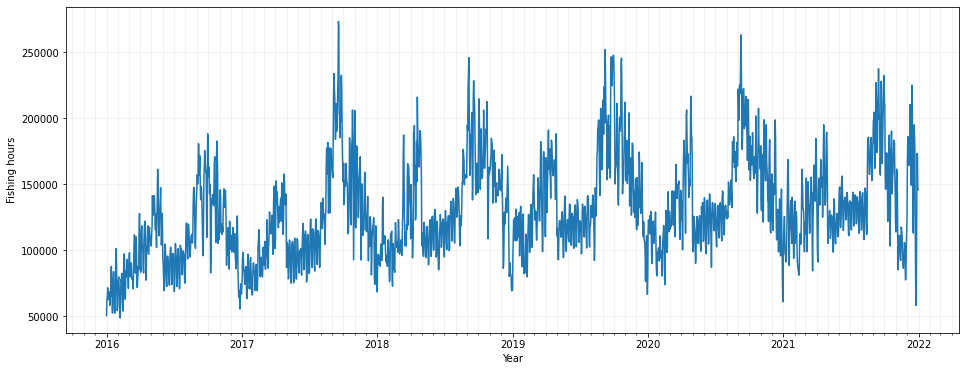

In [ ]:
# sum for each day
foo = fish[['date', 'fishing_hours']].groupby('date').sum()

# plot
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot('fishing_hours', data=foo)
ax.set_xlabel('Year')
ax.set_ylabel('Fishing hours')
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)
ax.grid(True, which='both', alpha=0.2)

I observe ... (fill in what you find)

**Q2:** Plot a global heatmap of fishing hours and observe the spatial patterns.

In [ ]:
# standardize fishing hours to unit area
# 1 degree is roughly 111 km at the equator and smaller at higher latitudes
fish['area_km2'] = 111 * 111 * np.cos(fish['lat'] * np.pi / 180)
fish['area_km2'] = fish['area_km2'].astype(float) #convert numpy float to pandas float
fish['fishing_hours_km2'] = fish['fishing_hours']/fish['area_km2']
fish.head()

,date,lat,lon,gear,flag,fishing_hours,area_km2,fishing_hours_km2
0,2016-01-01,-78,-178,set_longlines,RUS,16.628333,2561.679943,0.006491
1,2016-01-01,-78,-177,set_longlines,RUS,3.347222,2561.679943,0.001307
2,2016-01-01,-74,-118,set_longlines,UKR,17.537222,3396.127861,0.005164
3,2016-01-01,-74,-117,set_longlines,UKR,3.983611,3396.127861,0.001173
4,2016-01-01,-73,-180,set_longlines,RUS,21.068056,3602.311774,0.005848


In [ ]:
# sum over gear and flag within grids
summary = fish[['lat', 'lon', 'fishing_hours_km2']].groupby(['lat', 'lon']).sum()
summary.head()

fishing_hours_km2
lat lon                    
-79 -177           0.013842
    -176           0.018347
    -175           0.000592
-78 -180           0.022354
    -179           0.021237

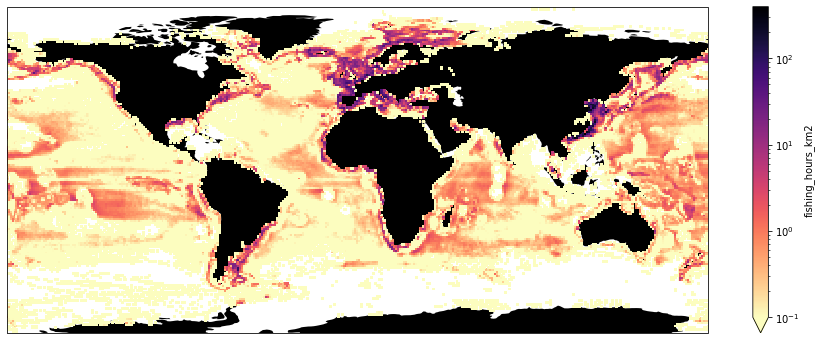

In [ ]:
# convert to xarray object for plotting
foo = summary.to_xarray()
foo['lat'] = foo['lat'].astype(int)
foo['lon'] = foo['lon'].astype(int)

# plot on a log scale
plt.figure(figsize=(16, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.axes.add_feature(cf.LAND, color='#000', linewidth=0)
foo['fishing_hours_km2'].plot(
    cmap="magma_r",
    norm=LogNorm(vmin=0.1, vmax=foo['fishing_hours_km2'].max()),
    ax=ax,
    add_colorbar=True
);

I observe ... (fill in what you find)

**Q3:** Plot latitudinal gradients of fishing hours over time.

In [ ]:
# transform from a long to wide format
# rows are latitude, columns are days
foo = fish.pivot_table(columns='date', index='lat', values='fishing_hours_km2', aggfunc=np.sum)
foo = foo.loc[::-1] # inverse rows
foo = foo.reindex(np.arange(-90, 90, 1)) # expand index range
foo.head()

date,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,2016-01-10,...,2021-12-22,2021-12-23,2021-12-24,2021-12-25,2021-12-26,2021-12-27,2021-12-28,2021-12-29,2021-12-30,2021-12-31
lat,,,,,,,,,,,,,,,,,,,,,
-90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


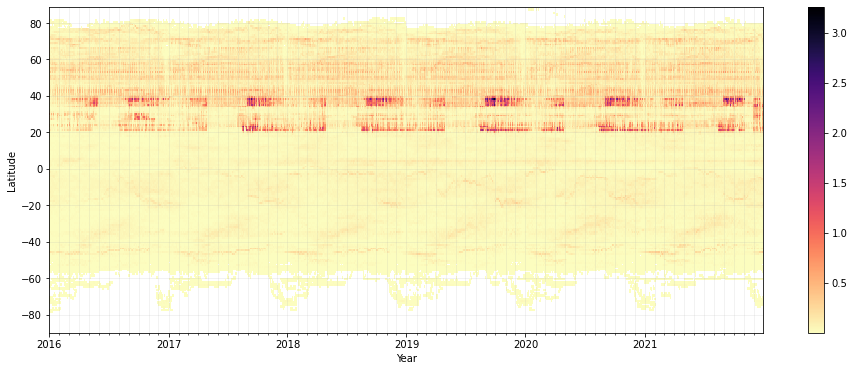

In [ ]:
# # plot heatmap
fig, ax = plt.subplots(figsize=(16, 6))
date = list(foo.columns)
lat = list(foo.index)
im = ax.pcolormesh(date, lat, foo.values, cmap='magma_r')
ax.set_xlabel('Year')
ax.set_ylabel('Latitude')
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)
ax.grid(True, which='both', alpha=0.2)
fig.colorbar(im, ax=ax);

## II. Explore Drivers Underlying Fishing Effort
### II.a. Biological drivers
Considering that humans are the top fish predators equipped with highly-advanced sensors, fishing activity should be strongly correlated with the fish distribution. However, we lack global data on fish distribution to support this. Therefore, we will look at a known correlate of fish abundance &mdash; primary production, which can be measured as chlorophyll a, a pigment in phytoplankton used for photosynthesis.

In this course, we will use NASA MODIS satellite imagery, pre-downloaded and pre-processed. MODIS (Moderate Resolution Imaging Spectroradiometer) satellite measures surface reflectance (color and temperature) in 36 spectral bands at spatial resolutions ranging from 250 m to 1 km, depending on the bands. The swath can cover the entire Earth in 1-2 days. We will use MODIS AQUA data.

**Q4:** Plot a heatmap of chlorophyll a.

In [ ]:
# read ocean climate data
modis = pd.read_parquet('./taking_the_pulse_ocean_data/modis.parquet')
modis.head()

,month,lat,lon,sst,chlor_a
0,2016-01,-89,-180,NaN,NaN
1,2016-01,-89,-179,NaN,NaN
2,2016-01,-89,-178,NaN,NaN
3,2016-01,-89,-177,NaN,NaN
4,2016-01,-89,-176,NaN,NaN


In [ ]:
# convert month string to datetime
modis['year_month'] = pd.to_datetime(modis['month'], format='%Y-%m')
modis.head()

,month,lat,lon,sst,chlor_a,year_month
0,2016-01,-89,-180,NaN,NaN,2016-01-01
1,2016-01,-89,-179,NaN,NaN,2016-01-01
2,2016-01,-89,-178,NaN,NaN,2016-01-01
3,2016-01,-89,-177,NaN,NaN,2016-01-01
4,2016-01,-89,-176,NaN,NaN,2016-01-01


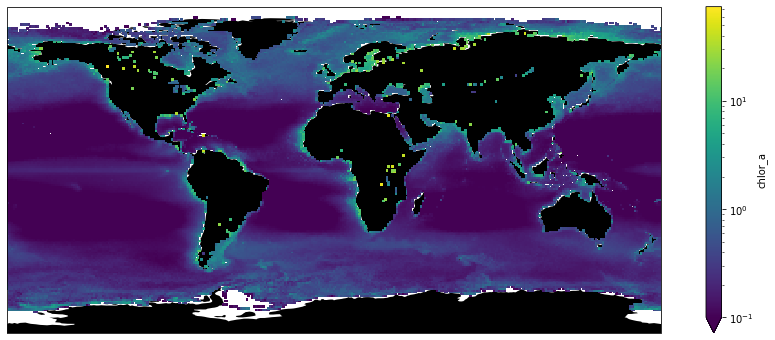

In [ ]:
# average chlor_a for each grid
summary = modis[['lat', 'lon', 'chlor_a']].groupby(['lat', 'lon']).mean()

# convert to xarray object for plotting
foo = summary.to_xarray()
foo['lat'] = foo['lat'].astype(int)
foo['lon'] = foo['lon'].astype(int)

# plot on a log scale
fig = plt.figure(figsize=(16, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.axes.add_feature(cf.LAND, color='#000', linewidth=0);
foo['chlor_a'].plot(
    cmap="viridis",
    norm=LogNorm(vmin=0.1, vmax=foo['chlor_a'].max()),
    ax=ax,
    add_colorbar=True
);

**Q5:** Plot mean chlorophyll a (x-axis) and fishing hours (y-axis) for each latitude, and test whether chlorophyll a explains fishing activity along latitudes using a linear regression.

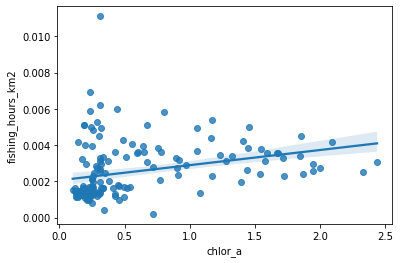

In [ ]:
# mean chlorophyll a within each latitude
foo = modis[['lat', 'chlor_a']].groupby('lat').mean()

# mean fishing hours within each latitude
bar = fish[['lat', 'fishing_hours_km2']].groupby('lat').mean()

# merge on index
foo['fishing_hours_km2'] = bar['fishing_hours_km2']
foo.reset_index(inplace=True)

# plot
sns.regplot(x='chlor_a', y='fishing_hours_km2', data=foo);

In [ ]:
# linear regression
# Is fishing effort explained by chlorophyll a concentration?

bar = foo[~foo.chlor_a.isnull()].copy()
model = sm.OLS(bar['fishing_hours_km2'], bar['chlor_a'])
result = model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:      fishing_hours_km2   R-squared (uncentered):                   0.524
Model:                            OLS   Adj. R-squared (uncentered):              0.521
Method:                 Least Squares   F-statistic:                              178.2
Date:                Mon, 26 Dec 2022   Prob (F-statistic):                    6.88e-28
Time:                        23:39:28   Log-Likelihood:                          778.64
No. Observations:                 163   AIC:                                     -1555.
Df Residuals:                     162   BIC:                                     -1552.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Q6:** Plot time series of chlorophyll a and fishing hours, respectively, and test how monthly fishing hours are correlated to chlorophyll a using cross correlation analysis.

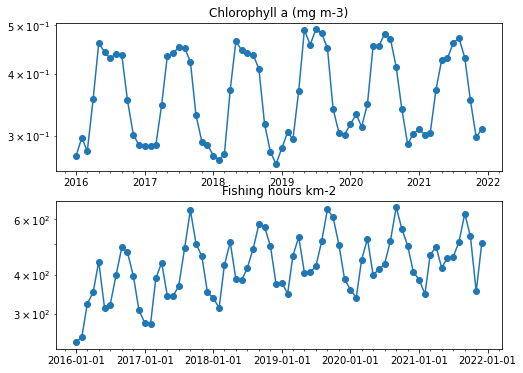

In [ ]:
# time series
# monthly total fishing hours to make same temporal resolutuions as modis data
fish['year'] = fish['date'].dt.year
fish['month'] = fish['date'].dt.month
fish['year_month'] = pd.to_datetime(fish['year']*100 + fish['month'], format='%Y%m')

fish_monthly = fish[['year_month', 'fishing_hours_km2']].groupby('year_month').sum()

# monthly mean chlorophyll a
foo = modis[['year_month', 'chlor_a']].groupby('year_month').mean()

foo['fishing_hours_km2'] = fish_monthly['fishing_hours_km2']
foo.reset_index(inplace=True)

# plot
fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot('year_month', 'chlor_a', data=foo, marker='o')
ax1.set_yscale('log')
ax1.title.set_text('Chlorophyll a (mg m-3)')
ax1.xaxis.set_minor_locator(mdates.MonthLocator(interval=2))

ax2.plot('year_month', 'fishing_hours_km2', data=foo, marker='o')
ax2.set_yscale('log')
ax2.title.set_text('Fishing hours km-2')
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_minor_locator(mdates.MonthLocator(interval=2));

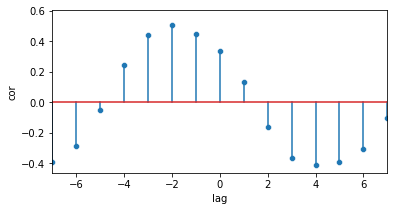

In [ ]:
# cross correlation
x1 = np.log(foo['chlor_a'])
x2 = np.log(foo['fishing_hours_km2'])

ccf_forward = sm.tsa.stattools.ccf(x1, x2, adjusted=False)
ccf_backward = sm.tsa.stattools.ccf(x2, x1, adjusted=False)[::-1]
ccf_output = np.r_[ccf_backward[:-1], ccf_forward]

# plot
ccf = pd.DataFrame({'lag':range(-71,72), 'cor':ccf_output})
plt.figure(figsize=(6, 3))
ax = sns.scatterplot(x='lag', y='cor', data=ccf)
ax.stem(ccf['lag'],ccf['cor'], markerfmt=' ')
ax.set_xlim(-7, 7);

The cross correlation analysis reveals that ... (fill in what you find)

I observe ... (fill in what you find).

### II.b. Non-biological drivers
Fishing activities are also shaped by other factors, such as holidays, COVID, and fuel prices. Also, fishing regulations should influence the activity. How strongly do they influence fishing activities?

**Q7:** Plot time series of fishing hours for Chinese-flagged vessels and non-Chinese-flagged vessels, respectively, and explore how fishing activities are influenced by social / cultural events.

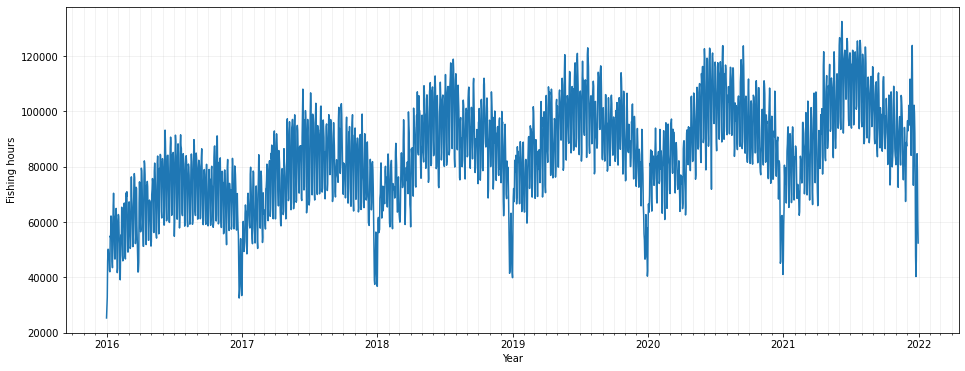

In [ ]:
# activity of non chinese-flagged vessels
other = fish[(fish['flag']!='CHN') | fish['flag'].isnull()].copy()

# sum each day
other_daily = other[['date', 'fishing_hours']].groupby('date').sum()

# plot
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot('fishing_hours', data=other_daily)
ax.set_xlabel('Year')
ax.set_ylabel('Fishing hours');
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)
ax.grid(True, which='both', alpha=0.2)

# ax.set_xlim([pd.datetime(2020, 1, 1), pd.datetime(2020, 12, 31)])

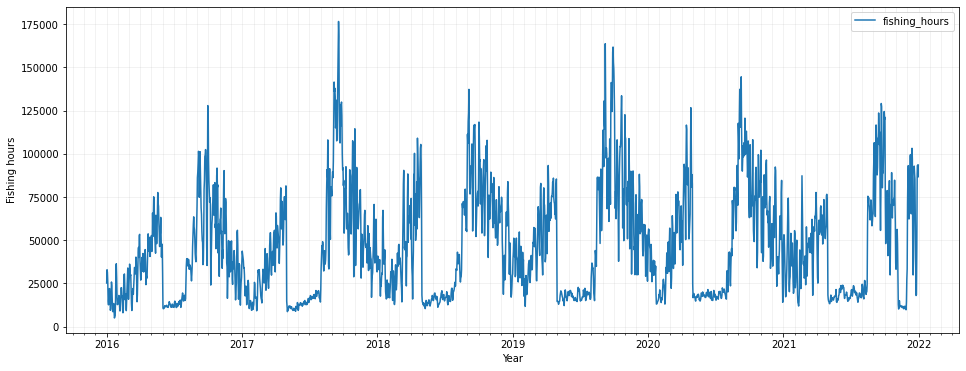

In [ ]:
# activity of chinese-flagged vessels
china = fish[fish['flag']=='CHN'].copy()

# sum each day
china_daily = china[['date', 'fishing_hours']].groupby('date').sum()

# plot
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot('fishing_hours', data=china_daily)
ax.set_xlabel('Year')
ax.set_ylabel('Fishing hours')
ax.legend()
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)
ax.grid(True, which='both', alpha=0.2)

I observe ...(fill in what you find)

**Q8:** Plot a heatmap fo high-resolution fishing hours for the area of your choice (Peru, Folkland Island, Pacific Islands, and West Africa), and explore how fishing activities are influenced by geospatial regulations by adding EEZ on the map.

In [113]:
# plot near Peru

data = pd.read_parquet('./taking_the_pulse_ocean_data/fishing_hours_peru.parquet')

data['area_km2'] = 111 * 111 * np.cos(data['lat'] * np.pi / 180)
data['area_km2'] = data['area_km2'].astype(float)
data['fishing_hours_km2'] = data['fishing_hours']/data['area_km2']

data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# change lat lon to integer (we want to sum within each grid but floating point causes problems when grouping)
data['lat'] = (data['lat'].values * 10).astype(int)
data['lon'] = (data['lon'].values * 10).astype(int)

# sum within each grid
summary = data[['lat', 'lon', 'fishing_hours_km2']].groupby(['lat', 'lon']).sum()
summary.head()

fishing_hours_km2
lat  lon                     
-300 -1000           0.002431
     -999            0.002721
     -998            0.001925
     -997            0.001872
     -996            0.002813

In [72]:
# read EEZ shapefile
eez = gpd.read_file('./taking_the_pulse_ocean_data/World_EEZ_v12')

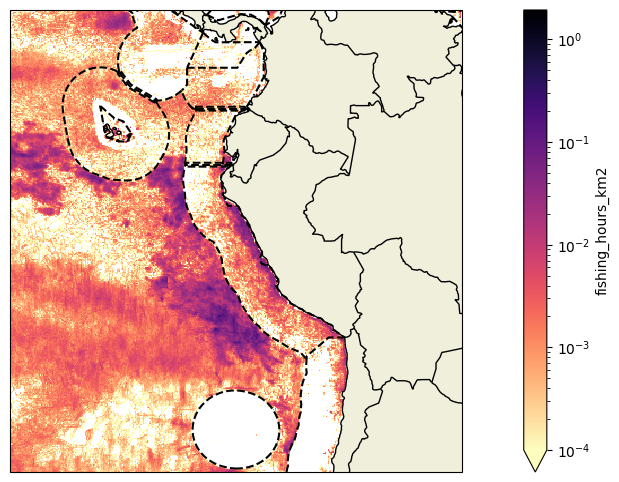

In [128]:
# plot
foo = summary.to_xarray()
foo['lat'] = 0.1*foo['lat']   # back to 0.1 degree intervals
foo['lon'] = 0.1*foo['lon']

# plot on a log scale
fig = plt.figure(figsize=(16, 6))
ax = plt.axes(projection=ccrs.PlateCarree())


eez.plot(ax=ax, color='black', linestyle='--')

foo['fishing_hours_km2'].plot(
    cmap="magma_r",
    norm=LogNorm(vmin=0.0001, vmax=foo['fishing_hours_km2'].max()),
    ax=ax, zorder=-1,
    add_colorbar=True
)

ax.add_feature(cf.LAND, linewidth=0)
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.COASTLINE)


ax.set_extent([-100, -60, -30, 10], crs=ccrs.PlateCarree())     # Peru (left, right, bottom, top)
#ax.set_extent([-40, 0, -10, 30], crs=ccrs.PlateCarree())   # West Africa
#ax.set_extent([140, 180, -35, 5], crs=ccrs.PlateCarree())   # Pacific islands

I observe ... (fill in what you find).

## III. Taking the Pulse in the Future

**Q10:** In this assignment, we worked with what we have in terms of sensors and data analysis workflows. If you were given $1 million to develop a new form of sensor or new form of data analysis, what would you do? This can be research, field work, fabrication of sensors, etc. Think about what you would measure, at what spatial and temporal scale and resolution. Over to you to design the next generation of sensors for taking the pulse of our oceans and fishing activity.

(your answer)

## Optional exercise
Explore fishing activity by gear type and explore the potential drivers. Choose fishing gear from { `drifting_longlines`, `trawlers`, `tuna_purse_seines`}. You can find the description of each gear type from the FAO website.

* [Trawlers](https://www.fao.org/fishery/en/geartype/103/en)
* [Drifting longlines](https://www.fao.org/fishery/en/geartype/233/en)
* [Purse seines](https://www.fao.org/fishery/en/geartype/102/en)



---
## Supplement
How to access original Global Fishing Watch data & NASA MODIS Terra data
#### Global Fishing Watch
- Online web map on their [website](https://globalfishingwatch.org/our-map/)
- R package `gfwr` ([link](https://github.com/GlobalFishingWatch/gfwr)) &mdash; an R API to download fishing data. Note that this is still at an early development stage.

#### NASA MODIS data
- The easiest way is to access the data on [Google Earth Engine](https://developers.google.com/earth-engine/datasets) through a Python API `earthengine-api` ([link](https://github.com/google/earthengine-api))
- You can also find the data on other repositories including [Amazon Web Service](https://aws.amazon.com/opendata/?wwps-cards.sort-by=item.additionalFields.sortDate&wwps-cards.sort-order=desc) or [Copernicus](https://cds.climate.copernicus.eu), or original data [NASA website](https://oceancolor.gsfc.nasa.gov).

(Note that AIS is mandated only for distant-water fleets engaging on international voyages, and therefore, it does not cover small-scale/artisanal fisheries in coastal areas and within EEZ. Also, some areas have low AIS coverage, including Southeastern Asia and the Gulf of Mexico. AIS devices can be tampered with or turned off.)

(Note that high primary production does not always favor fish growth. A combination of high temperature and nutrient runoff can cause harmful algal blooms, leading to hypoxic dead zones and fish kills. If you are interested, you can explore the relationship between chlorophyll-a `chlor_a`, sea surface temperature `sst` and particulate organic carbon `poc`, in MODIS data.)